# Aging Contact Surface

Predicting age of contact from contact interface gray-scale images.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import absolute_import, division, print_function
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
import re

In [4]:
image_folders = [filename for filename in os.listdir('./sub_images/')]

all_data = []
labels = []
times = []
normals = []
shears = []
indices = []

for folder in image_folders:
    # Get 3D matrix of data
    data = []
    label = []
    for filename in os.listdir('./sub_images/'+folder+'/'):
        if 'image' in filename:
            data.append(np.loadtxt('./sub_images/'+folder+'/'+filename, delimiter=',')) # read in img
            result = re.search('image(.*)x', filename) # get label from img filename
            label.append(float(result.group(1))) 
    all_data.append(data) # collect datas
    labels.append(label)
    stats = np.loadtxt('./sub_images/'+folder+'/folder_stats.csv', delimiter=',')
    # Append stats
    indices.append(stats[:,0])
    times.append(stats[:,1])
    shears.append(stats[:,2])
    normals.append(stats[:,3])

In [14]:
# Obtain target labels
time_labels = []
normal_labels = []
shear_labels = []
for i, label in enumerate(labels):
    time_label = []
    normal_label = []
    shear_label = []
    for lab in label:
        j = np.where(indices[i] == lab)
        time_label.append(times[i][j][0])
        normal_label.append(normals[i][j][0])
        shear_label.append(shears[i][j][0])
    time_labels.append(time_label)
    normal_labels.append(normal_label)
    shear_labels.append(shear_label)

In [61]:
# Assemble targets, shuffle data, and assign training and testing sets

for idx, data in enumerate(all_data):
    # Get data in right shape
    targets = np.vstack((time_labels[idx],normal_labels[idx],shear_labels[idx])).T
    data = np.dstack(data).T

    # Shuffle data and labels
    s = np.arange(data.shape[0])
    np.random.shuffle(s)
    threeD_data = data[s,:,:]
    targets = targets[s,:]

    # Split train and test
    train_size = round(0.8*data.shape[0])
    train_data = data[:train_size,:,:]
    test_data = data[train_size:,:,:]
    train_labels = targets[:train_size,:]
    test_labels = targets[train_size:,:]

In [47]:
def build_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(100,100)),
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(100,100)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(3)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return (model)

In [48]:
model = build_model()

In [37]:
# Build model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100,100)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)


# Compile model
model.compile(optimizer='sgd', 
              loss='mean_squared_error',
              metrics=['accuracy'])

In [49]:
model.fit(train_data, train_labels, epochs=5)
predictions=model.predict(test_data)

Epoch 1/5
7740/7740 [==============================] - 8s 1ms/step - loss: 10740.2140 - mean_absolute_error: 54.5232 - mean_squared_error: 10740.2140
Epoch 2/5
7740/7740 [==============================] - 7s 964us/step - loss: 5882.3542 - mean_absolute_error: 42.1342 - mean_squared_error: 5882.3542
Epoch 3/5
7740/7740 [==============================] - 8s 998us/step - loss: 5687.1785 - mean_absolute_error: 40.5047 - mean_squared_error: 5687.1785
Epoch 4/5
7740/7740 [==============================] - 8s 976us/step - loss: 5603.9942 - mean_absolute_error: 39.6558 - mean_squared_error: 5603.9942
Epoch 5/5
7740/7740 [==============================] - 8s 979us/step - loss: 5560.3670 - mean_absolute_error: 39.6022 - mean_squared_error: 5560.3670


R = 0.5489452467445713


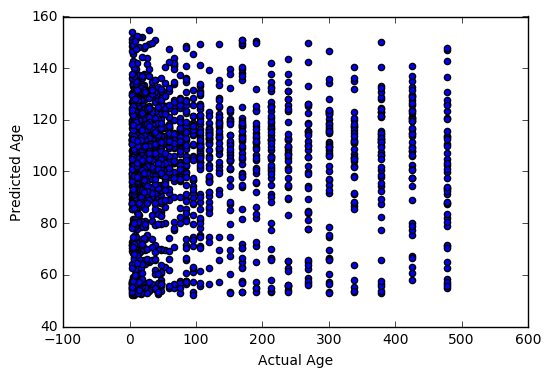

In [58]:
# Score and visualize predictions
from scipy.stats import pearsonr

actual_times = test_labels[:,0]
predicted_times = predictions[:,0]

print('R = '+str(pearsonr(actual_times, predicted_times)[1]))

plt.scatter(actual_times,predicted_times)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()